# by: Abdulrahman Saeed

## Netflix movie and TV show Clustering
This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

In this project, we worked on a text clustering problem where we had to classify/group the Netflix movie/shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.

- The dataset contained about 7787 records, and 11 attributes. 

- We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).

- Creating cluster using following attributes: director, cast, country, genre, rating and description. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.

- We used Principal Component Analysis (PCA) to handle the curse of dimensionality.

- Employing **K-Means Clustering and Agglomerative Hierarchical Clustering** algorithms, determining optimal cluster numbers through various evaluation methods.

- A content based recommender system was built using the similarity matrix obtained after using cosine similarity. This recommender system will make 10 recommendations to the user based on the type of show they watched.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv')
df.head()

show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-13     80 min   
4    January 1, 2020          2008  PG-13    123 min   

                                           listed_in  \
0  International TV Shows, TV Dramas, TV Sci-Fi &...   
1                       Dramas, International Movies   
2                Horror Movies, International Movies   
3  Action & Adventure, Independent Movies, Sci-Fi...   
4                                             Dramas   

                                         description  
0  In a future where the elite inhabit an island ...  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...  
3  In a postapocalyptic world, rag-doll robots hi...  
4  A brilliant group of students become card-coun...

### Basic Information of Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


#### Checking Missing Values

In [4]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

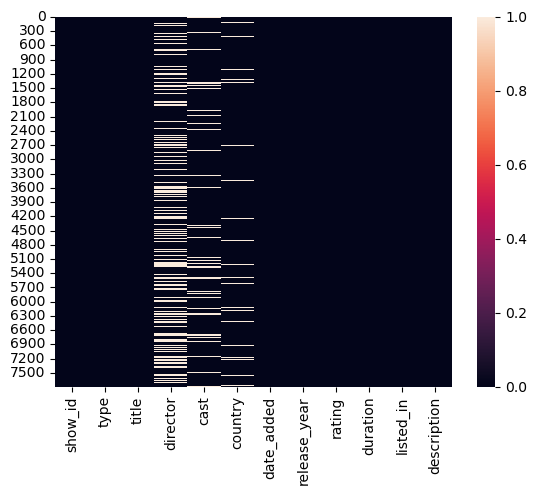

In [5]:
sns.heatmap(df.isnull(), cbar=True)
plt.show()

####  Handling Null values from each feature

In [6]:
df[['director','cast','country']] = df[['director','cast','country']].fillna('Missing')

In [7]:
df.dropna(axis=0, inplace=True)

In [8]:
df.isna().any().sum()

0

### Type Casting of attributes

In [9]:
df['date_added'] = pd.to_datetime(df['date_added'])

In [10]:
df['year_added'] = df['date_added'].dt.year

### rename 'listed_in' to 'genre'  and 'cast' to 'actor'

In [11]:
df.rename(columns={'listed_in':'genre'}, inplace=True)

### Separating Movies and TV Shows

In [12]:
df_movies= df[df['type']== 'Movie']
df_tvshows= df[df['type']== 'TV Show']

### EDA

#### Type column

In [13]:
labels = ['TV Show', 'Movie']
values = df.type.value_counts()

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text='Type of Content Watched on Netflix',)
fig.update_traces(marker=dict(colors=['#ffd700', '#008000']))

#### Rating column

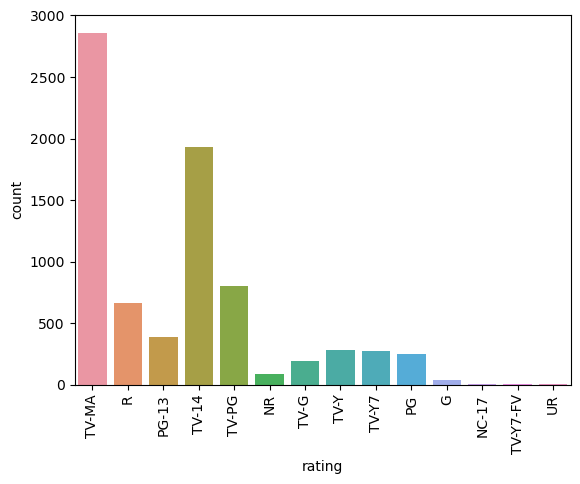

In [14]:
sns.countplot(data=df, x='rating')
plt.xticks(rotation=90)
plt.show()

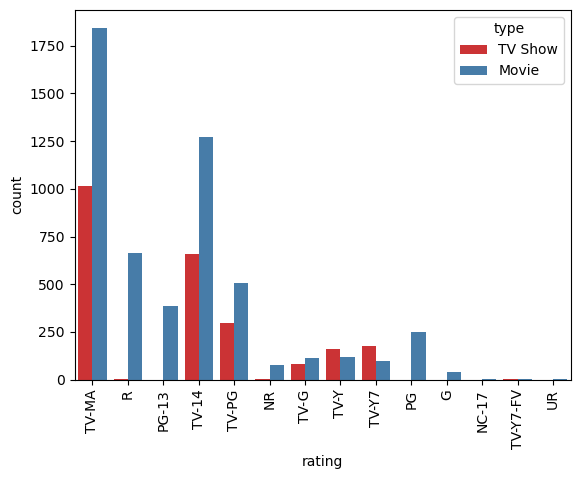

In [15]:
sns.countplot(data=df, x='rating', hue='type', palette='Set1')
plt.xticks(rotation=90)
plt.show()

#### Release_Year column

In [16]:
netflix_year_df = df['year_added'].value_counts().to_frame().reset_index().rename(columns={"index": "year", "year_added":"count"})
netflix_year_df.sort_values(by='year', ascending=False, inplace=True)

In [17]:
movies_year_df = df_movies['year_added'].value_counts().to_frame().reset_index().rename(columns={"index": "year", "year_added":"count"})
movies_year_df.sort_values(by='year', ascending=False, inplace=True)

In [18]:
shows_year_df = df_tvshows['year_added'].value_counts().to_frame().reset_index().rename(columns={"index": "year", "year_added":"count"})
shows_year_df.sort_values(by='year', ascending=False, inplace=True)

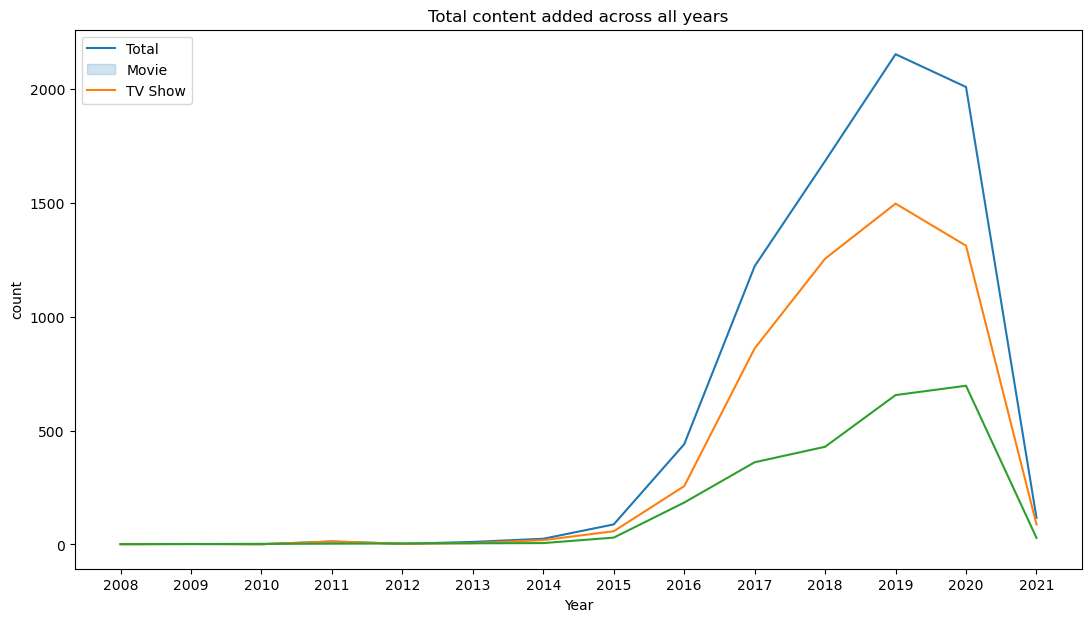

In [19]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot(data=netflix_year_df, x='year', y='count')
sns.lineplot(data=movies_year_df, x='year', y='count')
sns.lineplot(data=shows_year_df, x='year', y='count')
ax.set_xticks(np.arange(2008, 2022, 1))
plt.title("Total content added across all years")
plt.legend(['Total','Movie','TV Show'])
plt.xlabel("Year")
plt.show()

#### Country column

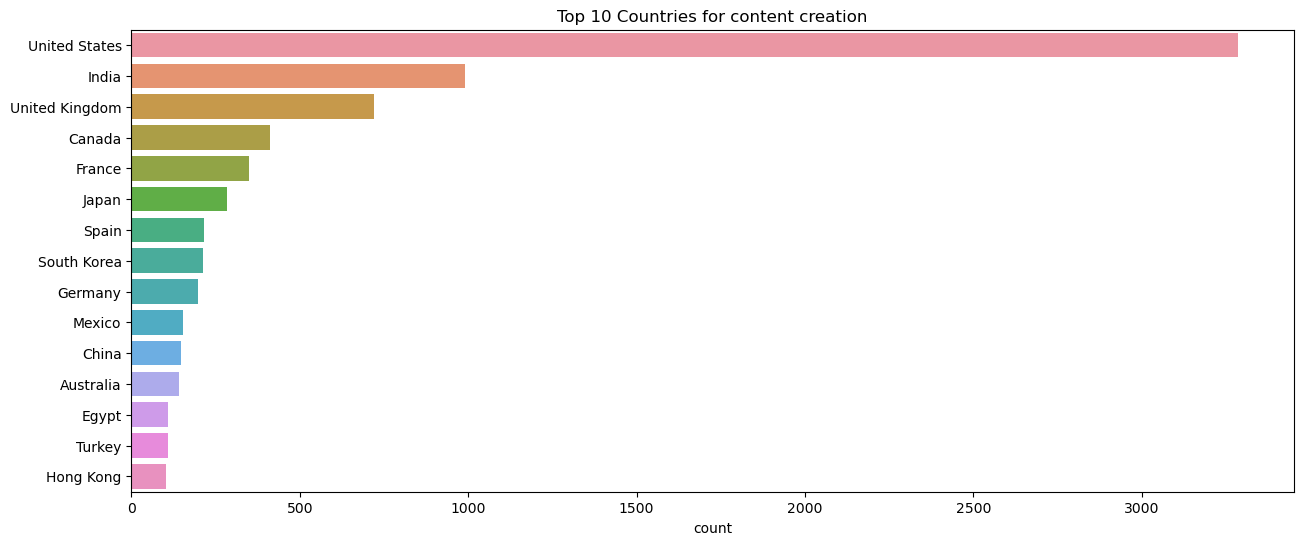

In [20]:
filtered_countries = df[df != 'Missing'].set_index('title').country.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
plt.figure(figsize=(15,6))
sns.countplot(y = filtered_countries, order=filtered_countries.value_counts().index[:15])
plt.title('Top 10 Countries for content creation')
plt.show()

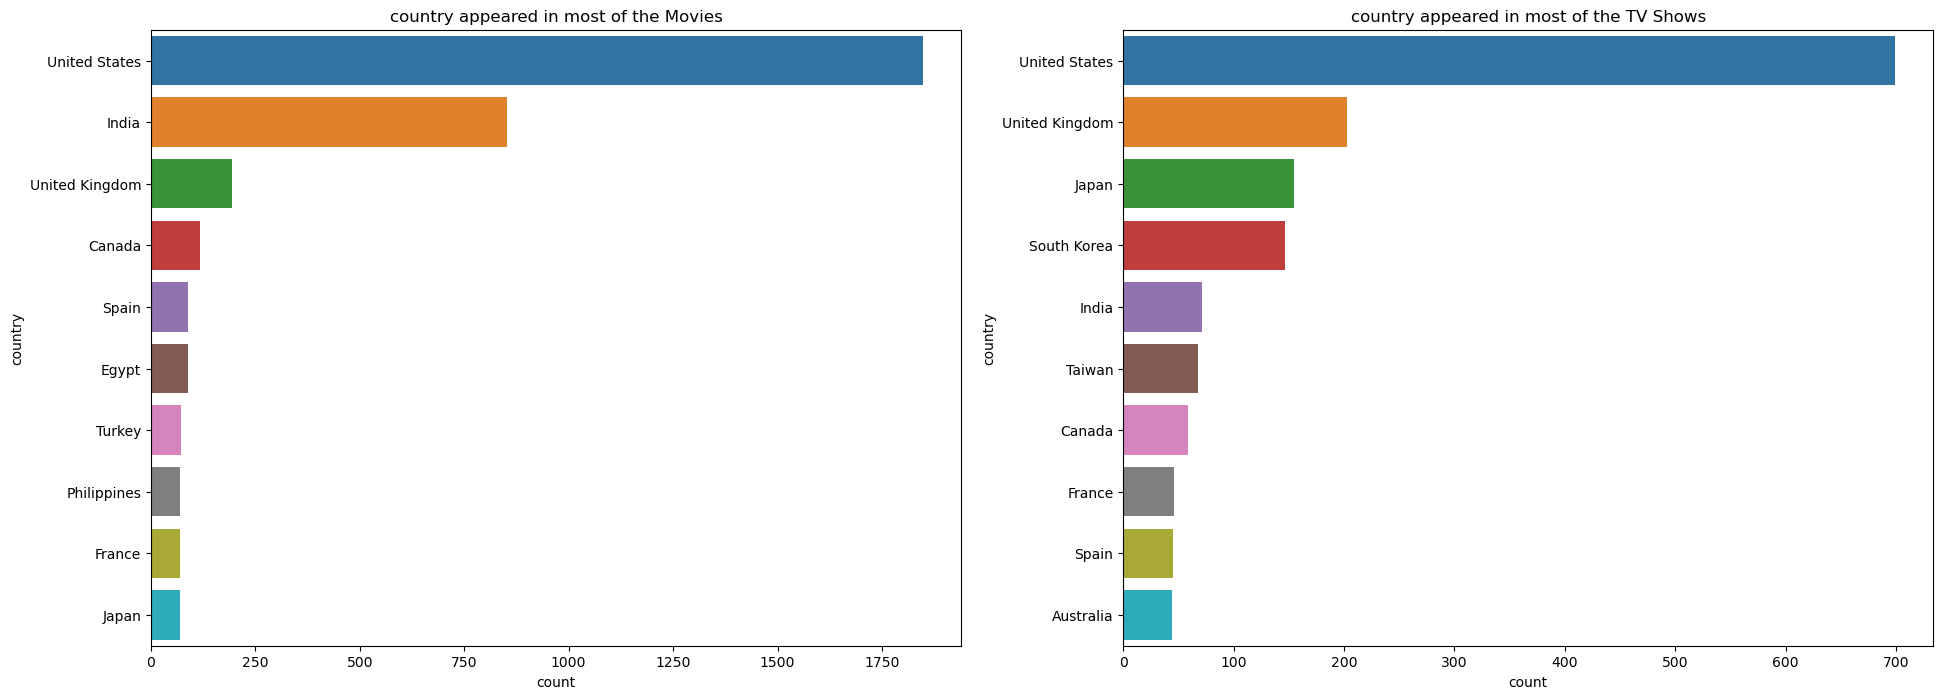

In [21]:
plt.figure(figsize=(23,8))
for i,j,k in ((df_movies, 'Movies',1),(df_tvshows, 'TV Shows',2)):
    i = i[i != 'Missing']
    plt.subplot(1,2,k)
    sns.countplot(data=i, y='country', order=i['country'].value_counts().index[:10])
    plt.title(f'country appeared in most of the {j}')
plt.show()

#### Director column

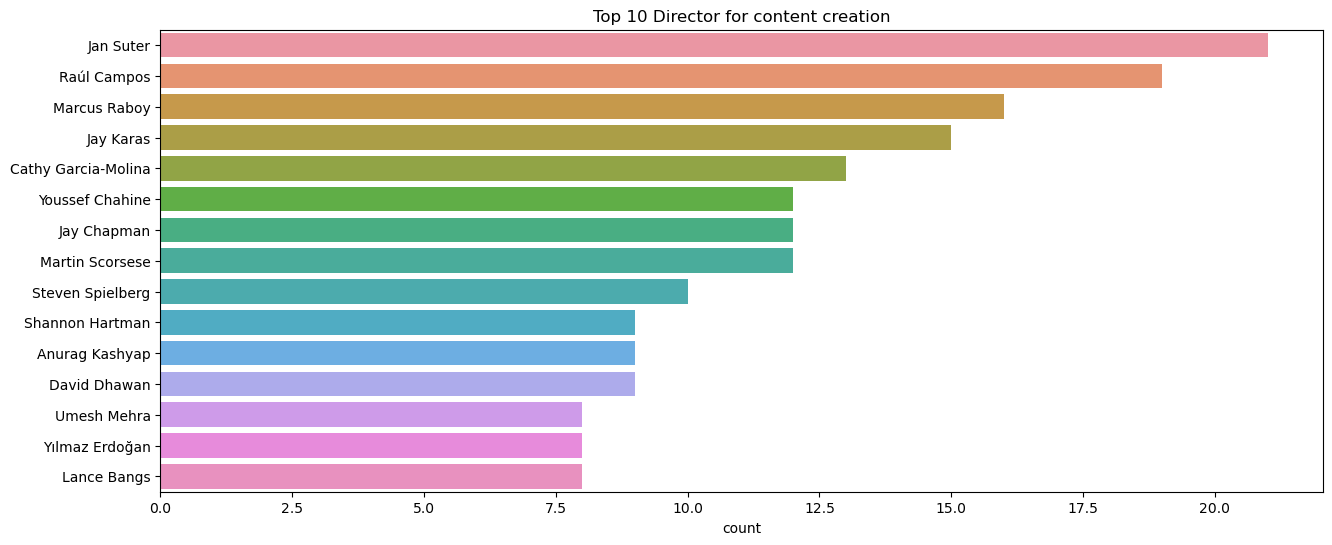

In [22]:
filtered_director = df[df != 'Missing'].set_index('title').director.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
plt.figure(figsize=(15,6))
sns.countplot(y = filtered_director, order=filtered_director.value_counts().index[:15])
plt.title('Top 10 Director for content creation')
plt.show()

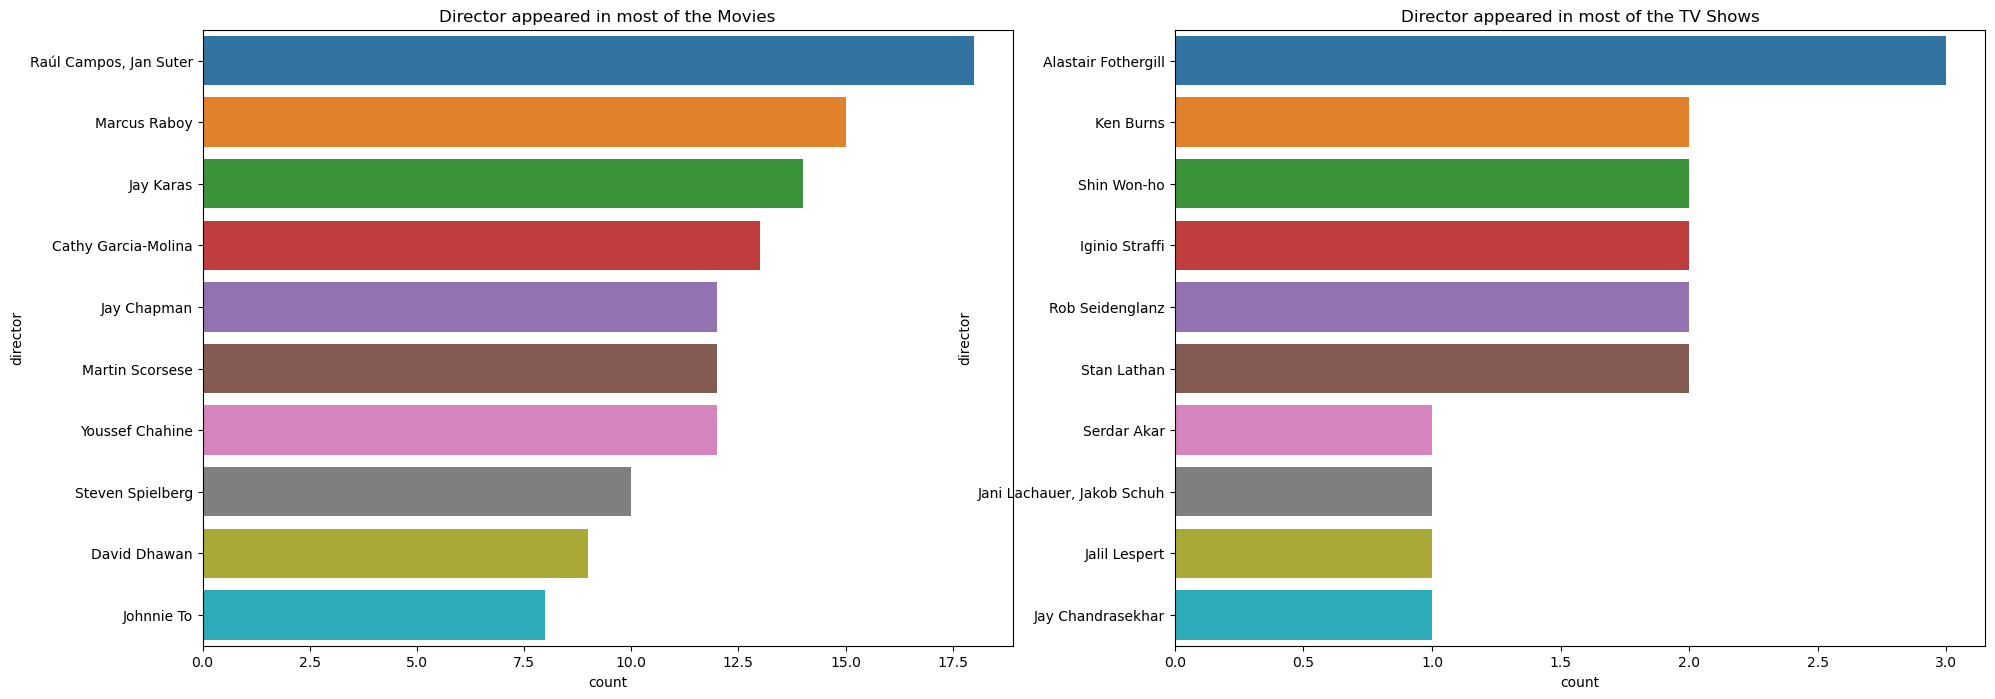

In [23]:
plt.figure(figsize=(23,8))
for i,j,k in ((df_movies, 'Movies',1),(df_tvshows, 'TV Shows',2)):
    i = i[i != 'Missing']
    plt.subplot(1,2,k)
    sns.countplot(data=i, y='director', order=i['director'].value_counts().index[:10])
    plt.title(f'Director appeared in most of the {j}')
plt.show()

#### Actor column

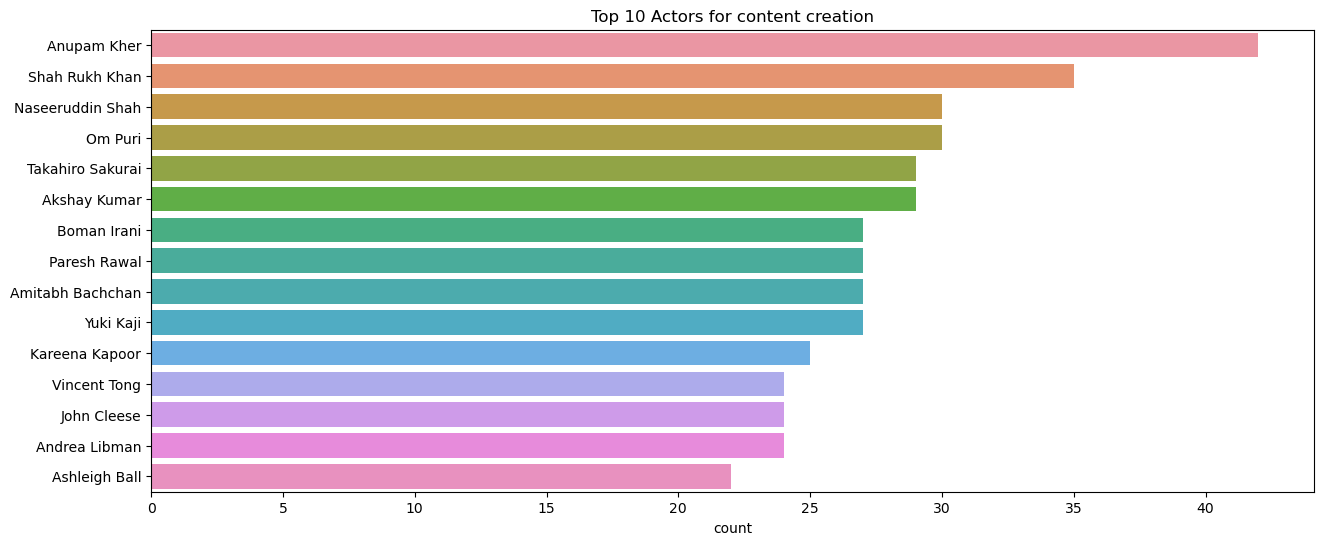

In [24]:
filtered_actor = df[df != 'Missing'].set_index('title').cast.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
plt.figure(figsize=(15,6))
sns.countplot(y = filtered_actor, order=filtered_actor.value_counts().index[:15])
plt.title('Top 10 Actors for content creation')
plt.show()

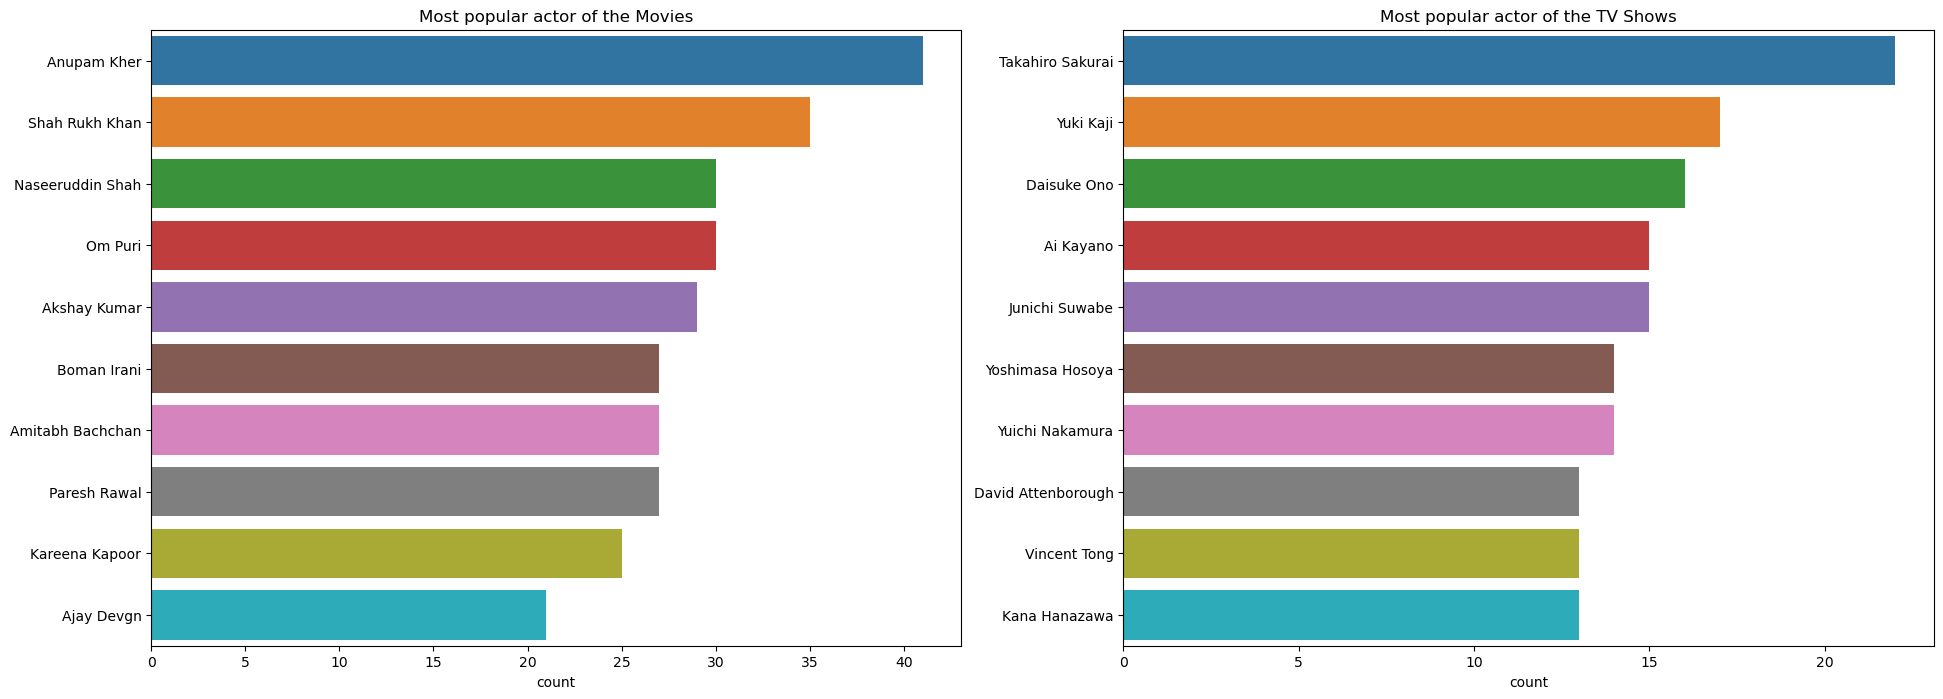

In [25]:
plt.figure(figsize=(23,8))
for i,j,k in ((df_movies, 'Movies',1),(df_tvshows, 'TV Shows',2)):
    filtered_cast = i[i['cast'] != 'Missing'].set_index('title')['cast'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
    plt.subplot(1,2,k)
    sns.countplot(y = filtered_cast, order=filtered_cast.value_counts().index[:10])
    plt.title(f'Most popular actor of the {j}')
plt.show()

#### Genre column

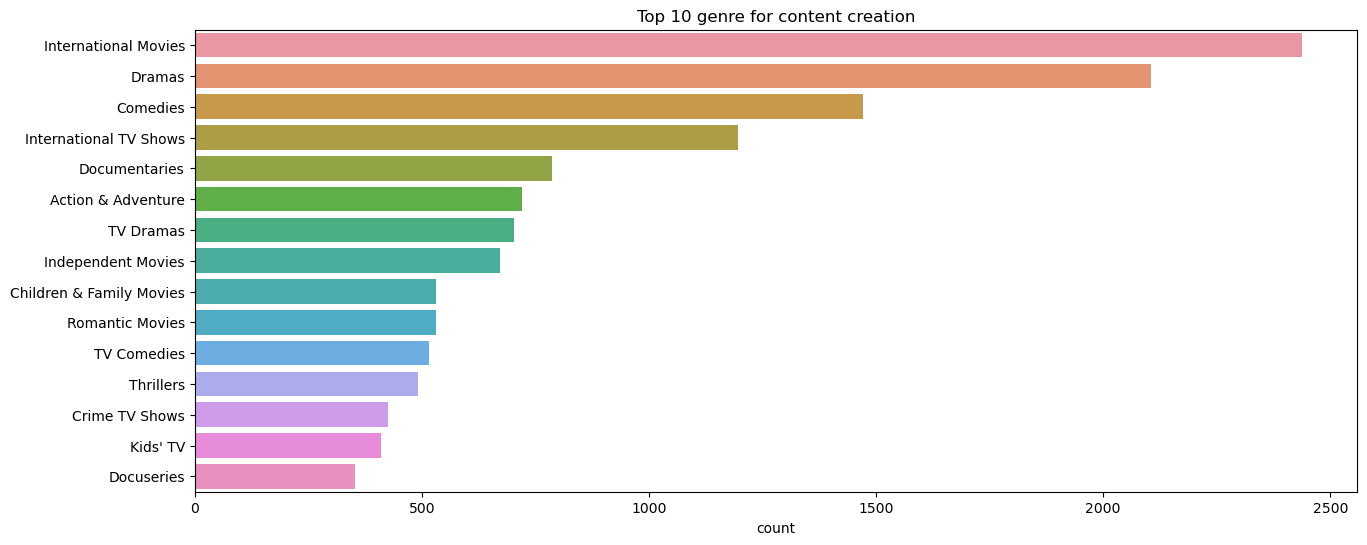

In [26]:
filtered_genre = df[df != 'Missing'].set_index('title').genre.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
plt.figure(figsize=(15,6))
sns.countplot(y=filtered_genre, order=filtered_genre.value_counts().index[:15])
plt.title('Top 10 genre for content creation')
plt.show()

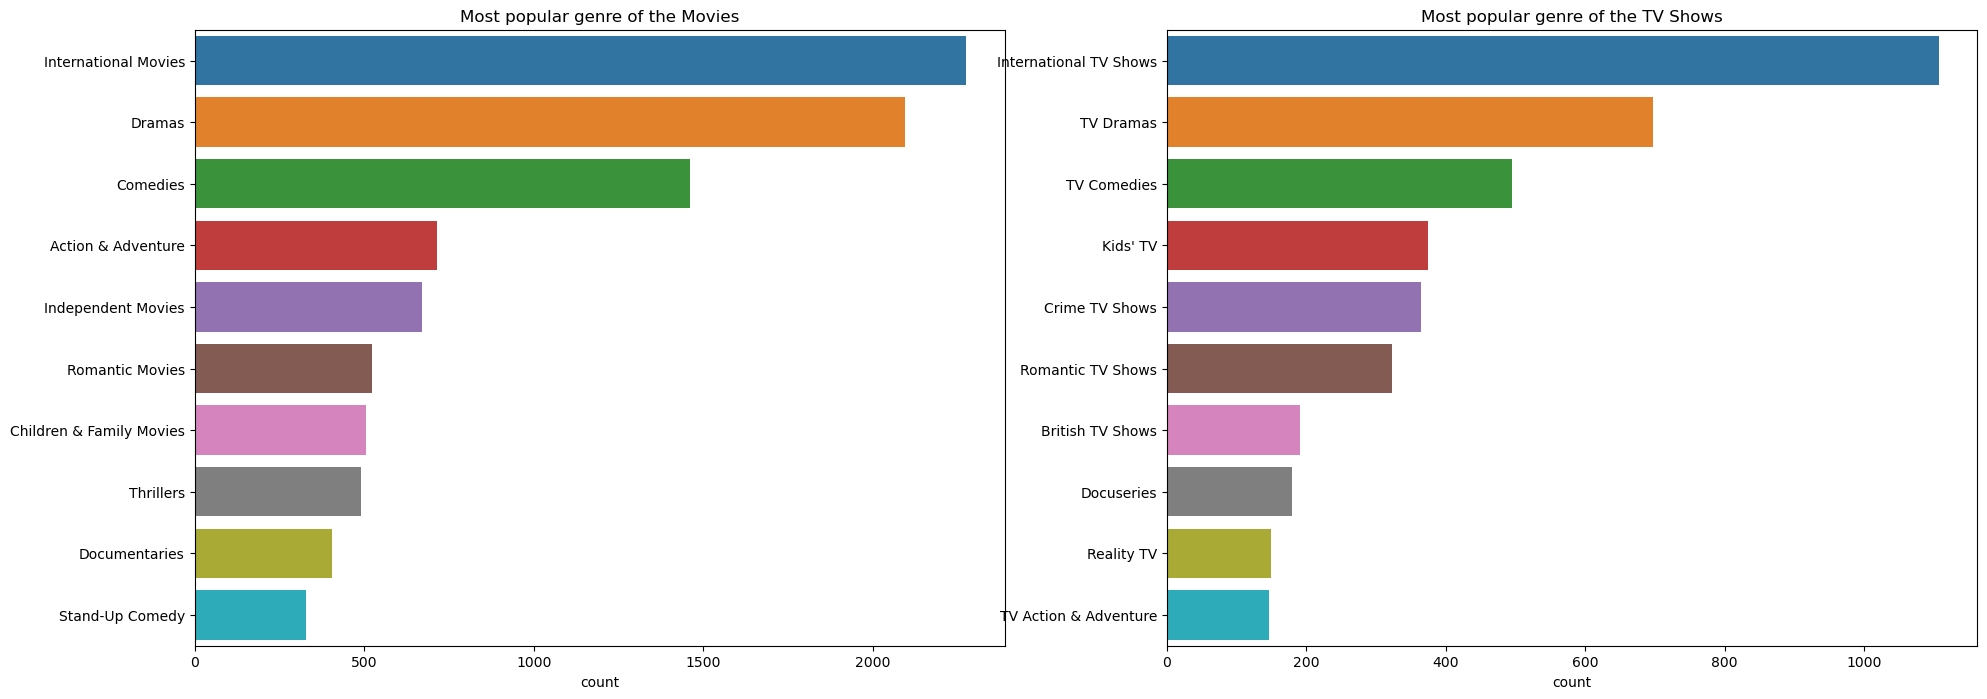

In [27]:
plt.figure(figsize=(23,8))
for i,j,k in ((df_movies, 'Movies',1),(df_tvshows, 'TV Shows',2)):
    filtered_genre = i[i['cast'] != 'Missing'].set_index('title')['genre'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
    plt.subplot(1,2,k)
    sns.countplot(y = filtered_genre, order=filtered_genre.value_counts().index[:10])
    plt.title(f'Most popular genre of the {j}')
plt.show()

### Handling Outlier

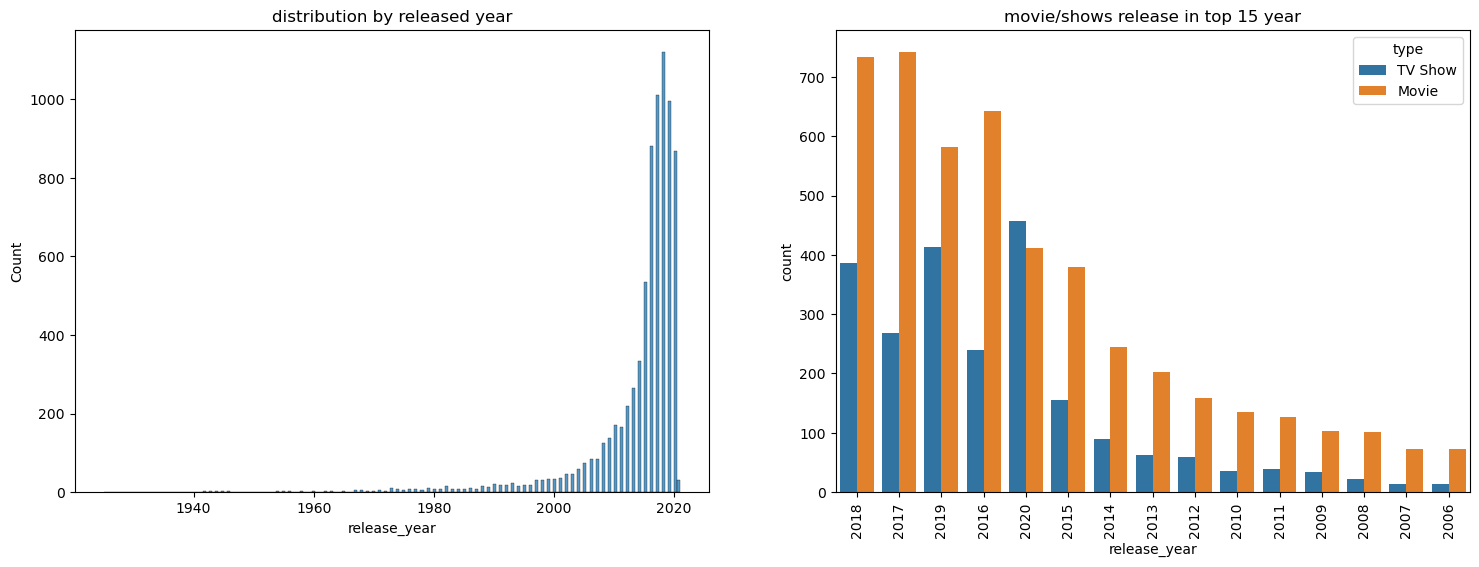

In [28]:
fig,ax = plt.subplots(1,2, figsize=(18,6))

# Univariate analysis
hist = sns.histplot(df['release_year'], ax=ax[0])
hist.set_title('distribution by released year')

# Bivariate analysis
count = sns.countplot(x="release_year", hue='type', data=df, order=df['release_year'].value_counts().index[0:15], ax=ax[1])
count.set_title('movie/shows release in top 15 year')
plt.xticks(rotation=90)

plt.show()

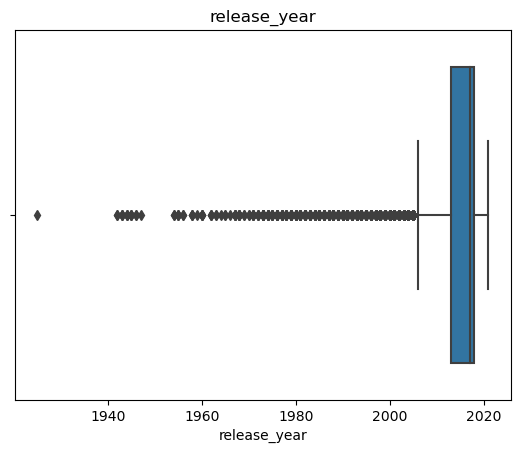

In [29]:
sns.boxplot(data=df, x='release_year')
plt.title('release_year')
plt.show()

- the almost all of the data present in textual format except release year.
- The data that we need to create cluster/building model are present in textual foramat. So, there is no need to perform handling outlier.

### Textual Data Preprocessing

**Modeling Approach**
1. Select the attributes based on which you want to cluster the shows
2. Text preprocessing: Remove all stopwords and punctuation marks, convert all textual data to lowercase.
3. Stemming to generate a meaningful word out of corpus of words.
4. Tokenization of corpus and Word vectorization
5. Dimensionality reduction
6. Use Kmeans algorithms to cluster the movies

In [30]:
df['content_detail'] = df['description'] + df['genre'] + df['rating'] + df['cast'] + df['country'] + df['director']

In [31]:
# download the stop words list if it is not already downloaded
nltk.download('stopwords')
# create a set of English stop words
stop_words = stopwords.words('english')

np.array(stop_words)

[nltk_data] Downloading package stopwords to C:\Users\Abdelrhman
[nltk_data]     Saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [32]:
def remove_punctuation_stopwords(text):
    '''a function for removing the stopword and lowercase the each word and punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    # joining the list of words with space separator
    text = " ".join(text)
    return text.translate(translator)

In [33]:
df['content_detail'] = df['content_detail'].apply(remove_punctuation_stopwords)

In [34]:
df.content_detail[0]

'future elite inhabit island paradise far crowded slums get one chance join 3 saved squalorinternational tv shows tv dramas tv scifi  fantasytvmajoão miguel bianca comparato michel gomes rodolfo valente vaneza oliveira rafael lozano viviane porto mel fronckowiak sergio mamberti zezé motta celso frateschibrazilmissing'

#### Stemming
Used SnowballStemmer to generate a meaningful word out of corpus of words.

Stemming is the process of reducing a word to its base or root form. This is a common pre-processing step in natural language processing (NLP) tasks, as it allows you to treat different inflected forms of a word as the same word, which can be useful for tasks like information retrieval or text classification.

For example, the words "run," "runs," "ran," and "running" are all different inflected forms of the same word "run," and a stemmer can reduce them all to the base form "run."

In [35]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [36]:
df['content_detail'] = df['content_detail'].apply(stemming)

In [37]:
df.content_detail[0]

'futur elit inhabit island paradis far crowd slum get one chanc join 3 save squalorintern tv show tv drama tv scifi fantasytvmajoão miguel bianca comparato michel gome rodolfo valent vaneza oliveira rafael lozano vivian porto mel fronckowiak sergio mamberti zezé motta celso frateschibrazilmiss'

#### Text Vectorization
Word/Text vectorization is the process of representing words as numerical vectors. This is important in NLP tasks because most machine learning models expect numerical input and cannot work with raw text data directly. Word vectorization allows you to input the words into a machine learning model in a way that preserve the meaning and context of the words. Word vectorization can also be used to measure the similarity between words using vector arithmetic.

In [38]:
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, max_features = 10000).fit(df['content_detail'])
vector = tfidf.transform(df['content_detail']).toarray()
vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

###  Dimesionality Reduction
We can use **PCA (Principal component Analysis)** to reduce the dimensionality of data.

Dimensionality reduction is the process of reducing the number of features or dimensions in a dataset while preserving as much information as possible. It is a common step in machine learning and data analysis, as high-dimensional datasets can be difficult to work with and can sometimes suffer from the curse of dimensionality.

In [39]:
pca = PCA(random_state=42)
pca.fit(vector)

PCA(random_state=42)

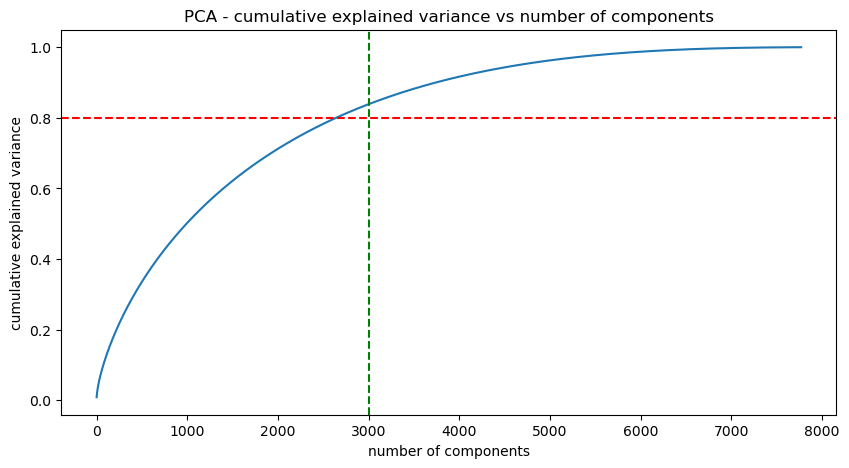

In [40]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y= 0.8, color='red', linestyle='--')
plt.axvline(x= 3000, color='green', linestyle='--')
plt.show()

- We find that 100% of the variance is explained by about ~7500 components.
- Also, more than 80% of the variance is explained just by 3000 components.
- Hence to simplify the model, and reduce dimensionality, we can take the top 3000 components, which will still be able to capture more than 80% of variance.

In [41]:
pca = PCA(n_components=3000, random_state=42)
pca.fit(vector)
X = pca.transform(vector)

### K-Means Clustering
K-means clustering is an unsupervised machine learning algorithm that is used to divide a dataset into a specified number of clusters. It is called "unsupervised" because the algorithm does not use any labeled examples to learn about the data. Instead, it relies on the inherent structure of the data to group the samples into clusters.

How It's Work?
1. The k-means algorithm works by first selecting k initial "centroids," or cluster centers, at random from the data. 
2. Then, it assigns each sample in the dataset to the nearest centroid, based on some distance metric like Euclidean distance. 
3. The algorithm then updates the centroids to be the mean of the samples in each cluster.
4. teratively repeats the process of reassigning samples to the nearest centroids and updating the centroids until convergence.


In [42]:
n_clusters = range(2, 16)
inertia_errors = []
silhouette_scores = []

for k in n_clusters:   
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(X)
    inertia_errors.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

In [43]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

In [44]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(x=n_clusters, y=silhouette_scores, title="K-Means Model: Silhouette Score vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")
fig.show()

In [45]:
model = KMeans(n_clusters=13, init='k-means++', random_state=42).fit(X)
df['kmeans_cluster'] = model.labels_

In [46]:
df.sample(5)[['type', 'title', 'director', 'cast', 'country', 'rating', 'genre', 'description', 'kmeans_cluster']]

type                    title                     director  \
7205    Movie                 Tree Man  Jon Reiner, Brad Rothschild   
5549    Movie  Shawn Mendes: In Wonder                 Grant Singer   
4982    Movie           Professor Mack            Christopher Nolen   
5985    Movie                   Target                 Raditya Dika   
3499  TV Show                  La Niña                      Missing   

                                                   cast        country rating  \
7205                                            Missing         Canada  TV-PG   
5549                                       Shawn Mendes  United States  TV-MA   
4982  Lisa Wu, Timon Kyle Durrett, Robert Christophe...  United States  TV-MA   
5985  Raditya Dika, Cinta Laura Kiehl, Samuel Rizal,...      Indonesia  TV-14   
3499  Ana María Estupiñán, Sebastian Eslava, Juan Se...       Colombia  TV-MA   

                                                  genre  \
7205                                      Documentaries   
5549                    Documentaries, Music & Musicals   
4982                          Comedies, Romantic Movies   
5985      Comedies, Horror Movies, International Movies   
3499  Crime TV Shows, International TV Shows, Spanis...   

                                            description  kmeans_cluster  
7205  Entrepreneurs from Vermont and Quebec sell Chr...               1  
5549  Over the course of a world tour, this unguarde...               4  
4982  When a confident college professor is courted ...               0  
5985  Trapped in an empty building, nine people are ...               5  
3499  A former Colombian guerrilla fighter faces cha...               7

Text(0.5, 1.0, 'Number of movies and TV shows in each cluster - Kmeans Clustering')

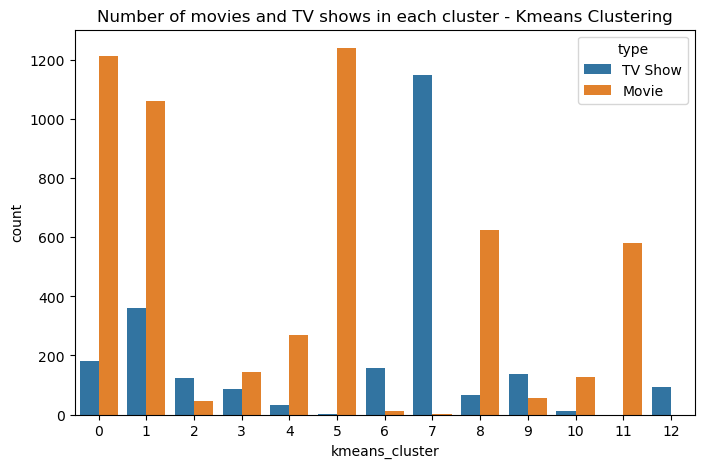

In [47]:
plt.figure(figsize=(8,5))
graph = sns.countplot(data=df, x='kmeans_cluster', hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')